In [2]:
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/javier/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy



In [20]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df = pd.read_csv('2020 - Semana 2 (12012020).txt',error_bad_lines=False,encoding = 'unicode_escape', 
                 header=3, sep='\t', skiprows=[4], skipinitialspace=True, 
                 usecols=['Título','Título/Descripción', 'Cadena', 'Fecha', 'Género','Público objetivo', 
                          'Productora','Calificación de Edad','Ind. 4+ (inv)','Amas de Casa (c/inv.)'
                          ,'Ind. 4 - 12 (c/inv.)', 'Ind. 16+ (c/inv.)','Ind. 4+ (inv).1','Amas de Casa (c/inv.).1',
                          'Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1'])

#ELIMINAMOS LAS CABECERAS DE LOS PROGRAMAS EN LA COLUMNA TÍTULO
df.dropna(inplace = True)
df = df[df.Título.str.startswith('<<')]
df.reset_index(drop = True,inplace = True)

#ELIMINAMOS LOS SIMBOLOS <> DEL DATA FRAME
df1 = pd.DataFrame()
for i in df.columns:
    df1 = pd.concat([df1,df.loc[:,str(i)].str.translate({ord(x): None for x in ('><')})], axis = 1)
    
#DIVIDIMOS LA COLUMNA EN DOS PARA PODER OPERAR SOLO CON LA HORA 
#(NO SE PUEDE PASAR A DATETIME YA QUE NO ESTÁ EN EL RANGO ADECUADO)
df1[['Hora','Minuto']] = df1.Título.str.split(':', expand = True)
#df1.head(5)

#PASAMOS LA COLUMNA FECHA A DATETIME PARA PODER RESTAR DIAS CUANDO SEA NECESARIO
df1['Fecha'] = pd.to_datetime(df1['Fecha'],format = "%d/%m/%Y", dayfirst=True)
#df1.dtypes

#SE CAMBIA EL TIPO DE DATO EN LAS COLUMNAS HORA MINUTO PARA PODER TRANSFORMAR A RANGO 00:00-23:00(STR-INT)
df1 = df1.astype({'Hora':'int','Minuto':'int'})
#df1.dtypes

#SUMAMOS 1 DÍA A LAS HORAS SUPERIORES A 23
ind = df1[df1['Hora']>23].index
df1.loc[ind,'Fecha']= df1.loc[ind,'Fecha'] + timedelta(days=1)

#CONVERTIMOS PARA TENER RANGO 00-23
df1.Hora = df1.Hora.replace({24:0,25:1,26:2})

#SE SUSTITUYE EL 24 POR 0 PARA TENER RANGO 00-23
#df1.Hora = df1.Hora.replace(24,0)


#CONVIERTO LA FECHA A STRING PARA PODER UNIRLO CON LA HORA
df1['Fecha']=df1.Fecha.apply(lambda x:str(x.date()))
df1[df1['Cadena']=='La1'].head(1413)

#VOLVEMOS A CONVERTIR HORA Y MINUTO A STR PARA PODER UNIRLOS CON ':' COMO SEPARADOR
df1 = df1.astype({'Hora':'str', 'Minuto':'str'})

#UNIMOS HORA Y MINUTO PARA DESPUÉS UNIRLO A LA FECHA Y CONVERTIRLO EN TIMESTAMP
df1 ['Tiempo'] = df1[['Hora', 'Minuto']].apply(lambda x: ':'.join(x), axis=1)
df1 ['Fecha_comp'] = df1[['Fecha', 'Tiempo']].apply(lambda x: ' '.join(x), axis=1)
df1.Fecha_comp = pd.to_datetime(df1.Fecha_comp)

#ELIMINAMOS LAS COLUMNAS GENERADAS Y USADAS PARA LAS TRANSFORMACIONES
df1 = df1.drop(['Tiempo','Hora', 'Minuto','Fecha','Título'], axis = 1)
#,'Descripción'

#CAMBIO COMA POR PUNTO PARA PODER CONVERTIR A ARRAY DE FLOAT
column = ['Ind. 4+ (inv)','Amas de Casa (c/inv.)', 'Ind. 4 - 12 (c/inv.)','Ind. 16+ (c/inv.)',
          'Ind. 4+ (inv).1','Amas de Casa (c/inv.).1','Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1']
for i in column:
    df1[i]=df1[i].str.replace(',','.')
    
#CREO LA VARIABLE TARGET CON LAS COLUMNAS NECESARIAS
df1['Target'] = df1['Ind. 4+ (inv).1'].apply(lambda x : float(x))
#df1['Target']= df1[column].apply(lambda x:'/'.join(x),axis=1)
#df1['Target']= df1.Target.str.split('/').apply(lambda x : [float(i) for i in x])
#df1['Target']= df1.Target.str.split('/').apply(lambda x:np.array(x,dtype=np.float32))

#ELIMINAMOS LAS VARIABLES UTILIZADAS EN TARGET
df1 = df1.drop(column,axis = 1)

#ELIMINAMOS TITULO/DESCRIPCION DE MOMENTO (!)
#df1 = df1.drop('Título/Descripción',axis = 1)

#ORDENO LAS COLUMNAS DE MI DATA FRAME (!) 
df1 = df1[['Fecha_comp','Título/Descripción','Cadena', 'Género', 'Público objetivo', 'Productora',
       'Calificación de Edad', 'Target']]

#ELIMINO CADENAS REGIONALES, YA QUE BUSCO ESTIMACIONES A NIVEL NACIONAL
cadenas_v = ['A3','LA SEXTA','NEOX','NOVA','MEGA','ATRESERIES','T5','CUATRO','DIVINITY','ENERGY','FDF','BEMADtv','DMAX'
             ,'DKISS','PARAMOUNT NETWORK','TEN','TRECE']
df1 = df1[df1['Cadena'].isin(cadenas_v)]

In [21]:
#PRUEBA DE DATAFRAME OBJETIVO PARA MODELO SARIMAX
#escogemos las columnas para copiar
pr = df1[['Fecha_comp','Cadena','Target']]

#SEPARAMOS DATAFRAMES EN CADENAS PARA DESARROLLAR LOS ALGORITMOS PERTINENTES PARA CADA UNO

grupos = pr.groupby('Cadena')

dfatrs = grupos.get_group('A3').groupby('Fecha_comp')['Target'].max().to_frame()
dfsxt = grupos.get_group('LA SEXTA').groupby('Fecha_comp')['Target'].max().to_frame()
dfnx = grupos.get_group('NEOX').groupby('Fecha_comp')['Target'].max().to_frame()
dfnv = grupos.get_group('NOVA').groupby('Fecha_comp')['Target'].max().to_frame()
dfmg = grupos.get_group('MEGA').groupby('Fecha_comp')['Target'].max().to_frame()
dfatrser = grupos.get_group('ATRESERIES').groupby('Fecha_comp')['Target'].max().to_frame()
dftcnc = grupos.get_group('A3').groupby('Fecha_comp')['Target'].max().to_frame()
dfctr = grupos.get_group('CUATRO').groupby('Fecha_comp')['Target'].max().to_frame()
dfdvnt = grupos.get_group('DIVINITY').groupby('Fecha_comp')['Target'].max().to_frame()
dfnrg = grupos.get_group('ENERGY').groupby('Fecha_comp')['Target'].max().to_frame()
dffdf = grupos.get_group('FDF').groupby('Fecha_comp')['Target'].max().to_frame()
dfbmd = grupos.get_group('BEMADtv').groupby('Fecha_comp')['Target'].max().to_frame()
dfdmx = grupos.get_group('DMAX').groupby('Fecha_comp')['Target'].max().to_frame()
dfdks = grupos.get_group('DKISS').groupby('Fecha_comp')['Target'].max().to_frame()
dfprmnt = grupos.get_group('PARAMOUNT NETWORK').groupby('Fecha_comp')['Target'].max().to_frame()
dftn = grupos.get_group('TEN').groupby('Fecha_comp')['Target'].max().to_frame()
dftrc = grupos.get_group('TRECE').groupby('Fecha_comp')['Target'].max().to_frame()

In [18]:
#CREAMOS LOS CSVs VACÍOS PARA ALMACENAR LOS DFs DE CADENA
data_prueba = pd.DataFrame(columns=['Target'])
data_prueba.to_csv('Data_Frame_algoritm_dfatrs.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfsxt.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfnx.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfnv.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfmg.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfatrser.csv')
data_prueba.to_csv('Data_Frame_algoritm_dftcnc.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfctr.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfdvnt.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfnrg.csv')
data_prueba.to_csv('Data_Frame_algoritm_dffdf.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfbmd.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfdmx.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfdks.csv')
data_prueba.to_csv('Data_Frame_algoritm_dfprmnt.csv')
data_prueba.to_csv('Data_Frame_algoritm_dftn.csv')
data_prueba.to_csv('Data_Frame_algoritm_dftrc.csv')

In [22]:
#GUARDAMOS LOS DF DE CADENA EN ARCHIVOS CSV CREADOS PREVIAMENTE PARA CONCATENAR EL PROCESADO DE LOS DATOS
dfatrs.to_csv('Data_Frame_algoritm_dfatrs.csv', mode = 'a', header = False)
dfsxt.to_csv('Data_Frame_algoritm_dfsxt.csv', mode = 'a', header = False)
dfnx.to_csv('Data_Frame_algoritm_dfnx.csv', mode = 'a', header = False)
dfnv.to_csv('Data_Frame_algoritm_dfnv.csv', mode = 'a', header = False)
dfmg.to_csv('Data_Frame_algoritm_dfmg.csv', mode = 'a', header = False)
dfatrser.to_csv('Data_Frame_algoritm_dfatrser.csv', mode = 'a', header = False)
dftcnc.to_csv('Data_Frame_algoritm_dftcnc.csv', mode = 'a', header = False)
dfctr.to_csv('Data_Frame_algoritm_dfctr.csv', mode = 'a', header = False)
dfdvnt.to_csv('Data_Frame_algoritm_dfdvnt.csv', mode = 'a', header = False)
dfnrg.to_csv('Data_Frame_algoritm_dfnrg.csv', mode = 'a', header = False)
dffdf.to_csv('Data_Frame_algoritm_dffdf.csv', mode = 'a', header = False)
dfbmd.to_csv('Data_Frame_algoritm_dfbmd.csv', mode = 'a', header = False)
dfdmx.to_csv('Data_Frame_algoritm_dfdmx.csv', mode = 'a', header = False)
dfdks.to_csv('Data_Frame_algoritm_dfdks.csv', mode = 'a', header = False)
dfprmnt.to_csv('Data_Frame_algoritm_dfprmnt.csv', mode = 'a', header = False)
dftn.to_csv('Data_Frame_algoritm_dftn.csv', mode = 'a', header = False)
dftrc.to_csv('Data_Frame_algoritm_dftrc.csv', mode = 'a', header = False)


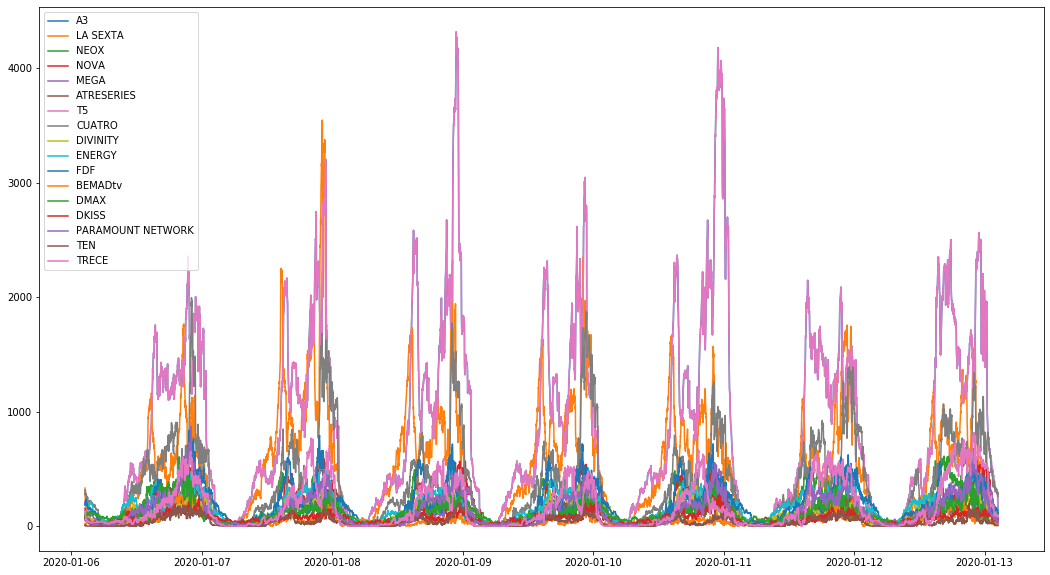

In [28]:
#VISUALIZACIÓN SIMPLE DEL ÚLTIMO DF CREADO. ABRIR EL ARCHIVO CONCATENADO PARA TRATAR CON TODOS LOS REGISTROS PROCES

plt.figure(figsize=(18,10))
plt.plot(dfatrs)
plt.plot(dfsxt)
plt.plot(dfnx)
plt.plot(dfnv)
plt.plot(dfmg)
plt.plot(dfatrser)
plt.plot(dftcnc)
plt.plot(dfctr)
plt.plot(dfdvnt)
plt.plot(dfnrg)
plt.plot(dffdf)
plt.plot(dfbmd)
plt.plot(dfdmx)
plt.plot(dfdks)
plt.plot(dfprmnt)
plt.plot(dftn)
plt.plot(dftrc)


plt.legend(cadenas_v)

In [4]:
#ANALIZAMOS LOS CEROS POR CADA CADENA Y ALMACENAMOS LAS CADENAS QUE NOS INTERESAN
dff = df1.reset_index()
#dff.Target = dff.Target.map(lambda x : x[4])
dfc = dff.groupby(['Fecha_comp','Cadena'])['Target'].max().unstack(level = 'Cadena')

#col_z = ['NOVA','CLAN','LA SEXTA','A3','T5','24H','La2','CUATRO']
#dfcg = dfc.loc[:,'Cadena']

#dfz.to_excel('Valores_a_cero.xlsx')
dfc.loc[:,'La2'].loc[lambda x : x==0.0]

Cadena,A3,ATRESERIES,BEMADtv,CUATRO,DIVINITY,DKISS,DMAX,ENERGY,FDF,LA SEXTA,MEGA,NEOX,NOVA,PARAMOUNT NETWORK,T5,TEN,TRECE
Fecha_comp,,,,,,,,,,,,,,,,,
2020-01-06 02:30:00,185.525,108.509,18.456,282.231,126.178,64.862,83.624,191.450,185.412,332.757,133.393,87.548,156.741,53.356,105.576,5.065,131.048
2020-01-06 02:31:00,197.604,101.733,23.700,272.024,119.231,64.862,89.638,189.198,201.166,291.059,130.852,75.160,151.459,48.766,117.629,9.559,114.294
2020-01-06 02:32:00,200.188,98.678,18.456,278.888,116.646,64.862,96.576,191.024,216.124,204.704,130.852,65.329,151.459,51.017,107.823,9.559,105.043
2020-01-06 02:33:00,202.510,73.912,18.456,290.301,116.646,64.862,96.576,181.858,216.124,197.642,129.603,65.555,151.459,51.013,107.232,5.065,105.043
2020-01-06 02:34:00,211.764,66.965,18.456,316.164,116.646,64.862,96.576,197.621,218.578,183.132,135.870,72.501,115.263,51.013,93.120,5.065,112.403


In [7]:
#REVISAMOS QUE HAYA CONTINUIDAD EN LA MARCA HORARIA
#RESETEAR INDICE
df2 = df1.sort_values('Fecha_comp')
df2.reset_index(drop = True,inplace = True)
counter = 0 
for i in df2.index:
    if i >= 1:
        if  (df2.Fecha_comp[i] - df2.Fecha_comp[i-1] > timedelta(minutes=1)):
            print(i)
            print(df1.iloc[i,:])
            counter+=1
    
    
print(counter)

0


In [45]:
import pmdarima as pm

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [ ]:
model = pm.auto_arima(
    pr3,
    m = 12,
    suppress_warnings=True
)

In [ ]:
model.summary()

In [12]:
#PLOTEAR EL DATAFRAME OBJETIVO
#audiencia media de todo el dataset disponible
dmin = ser.index.min()
dmax = ser.index.max()
amin = 0
amax = ser.values.max()

fig = go.Figure(data=go.Scatter(x=ser.index, y= ser.values), 
                layout={'xaxis':{'range':[dmin, dmax]},
                        'yaxis':{'range':[amin, amax]}})
fig.show()

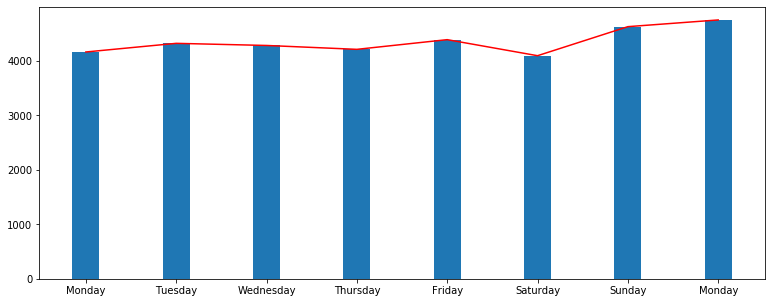

In [13]:
#PLOTEAMOS LA AUDIENCIA MEDIA POR DÍA DE LA SEMANA
df_sem = pr3.groupby(pd.Grouper(freq = 'D' )).mean()

f, ax = plt.subplots(figsize=(13,5))
plt.bar(df_sem.index, df_sem['Target'].values, width= 0.3, tick_label = df_sem.index.day_name())
plt.plot(df_sem, color = 'red')

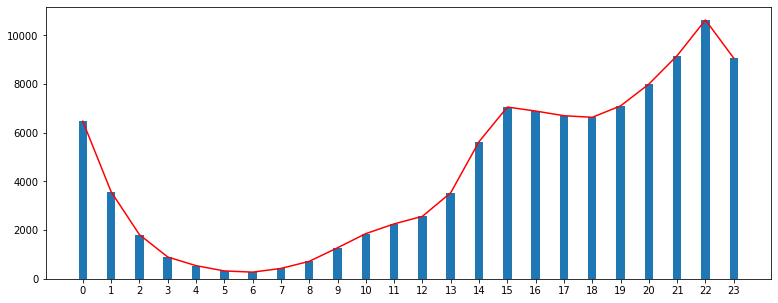

In [14]:
#PLOTEAMOS LA AUDIENCIA MEDIA POR HORA
df_hora = pr3.groupby(pr3.index.hour).mean()

f, ax = plt.subplots(figsize=(13,5))
plt.bar(df_hora.index, df_hora['Target'].values, width= 0.3,tick_label = df_hora.index)
plt.plot(df_hora, color = 'red')

In [ ]:
datetime.datetime.combine(datetime.date(2011, 01, 01), datetime.time(10, 23))

In [43]:
df_h_d.index.get_level_values(1)

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
            ...
            17, 18, 19, 20, 21, 22, 23,  0,  1,  2],
           dtype='int64', name='Fecha_comp', length=121)

In [56]:
df_h_d.index[0][1]

2

In [57]:
datetime.datetime.combine(df_h_d.index[0][0], datetime.time(df_h_d.index[0][1],0))

datetime.datetime(2020, 1, 1, 2, 0)

In [58]:
df_h_d.index = df.index.map(lambda x : datetime.datetime.combine(x[0], datetime.time([x[1],0])) )

TypeError: 'int' object is not subscriptable

In [68]:
pr3.groupby([pr3.timedelta(hours = 1)]).mean()

KeyError: datetime.timedelta(seconds=3600)

In [23]:

df_h_d = pr3.groupby([pr3.index.date, pr3.index.hour]).mean()

#f, ax = plt.subplots(figsize=(13,5))
#plt.plot(df_h_d['Ind. 4+ (inv).1'], color = 'red')
ind = df_h_d.index.to_flat_index()
ind

Index([ (2020-01-01, 2),  (2020-01-01, 3),  (2020-01-01, 4),  (2020-01-01, 5),
        (2020-01-01, 6),  (2020-01-01, 7),  (2020-01-01, 8),  (2020-01-01, 9),
       (2020-01-01, 10), (2020-01-01, 11),
       ...
       (2020-01-05, 17), (2020-01-05, 18), (2020-01-05, 19), (2020-01-05, 20),
       (2020-01-05, 21), (2020-01-05, 22), (2020-01-05, 23),  (2020-01-06, 0),
        (2020-01-06, 1),  (2020-01-06, 2)],
      dtype='object', length=121)

In [34]:
df_h_d.index[120]

(datetime.date(2020, 1, 6), 2)

/home/javier/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.

/home/javier/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.



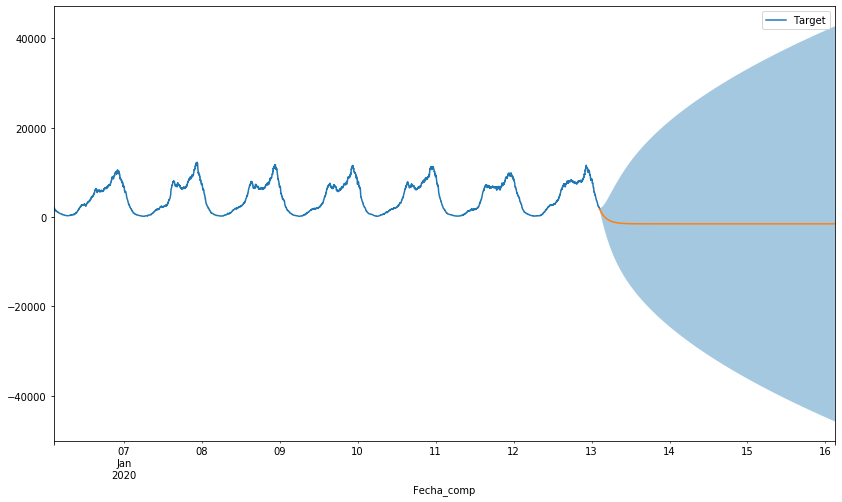

In [10]:
model = SARIMAX(pr3, order = (3, 1, 1)).fit()
prediction = model.get_forecast(steps = 4350)
lower = prediction.conf_int()["lower Target"]
upper = prediction.conf_int()["upper Target"]
fig, ax = plt.subplots()
pr3.truncate(before = "2020-01-04 02:30:00").plot(ax = ax,figsize = (14, 8))
prediction.predicted_mean.plot(ax = ax)
ax.fill_between(lower.index, lower, upper, alpha = 0.4)
plt.show()

In [84]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Target   No. Observations:                 7200
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -38431.685
Date:                Tue, 11 Aug 2020   AIC                          76873.370
Time:                        14:02:32   BIC                          76907.779
Sample:                    01-01-2020   HQIC                         76885.210
                         - 01-06-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1849      0.009    138.903      0.000       1.168       1.202
ar.L2         -0.1510      0.012    -12.093      0.000      -0.175      -0.127
ar.L3         -0.0390      0.009     -4.566      0.000      -0.056      -0.022
ma.L1         -0.9675      0.004   -239.760      0.000      -0.975      -0.960
sigma2      2537.5996     21.875    116.006      0.000    2494.726    2580.473
===================================================================================
Ljung-Box (Q):                       92.73   Jarque-Bera (JB):             11417.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

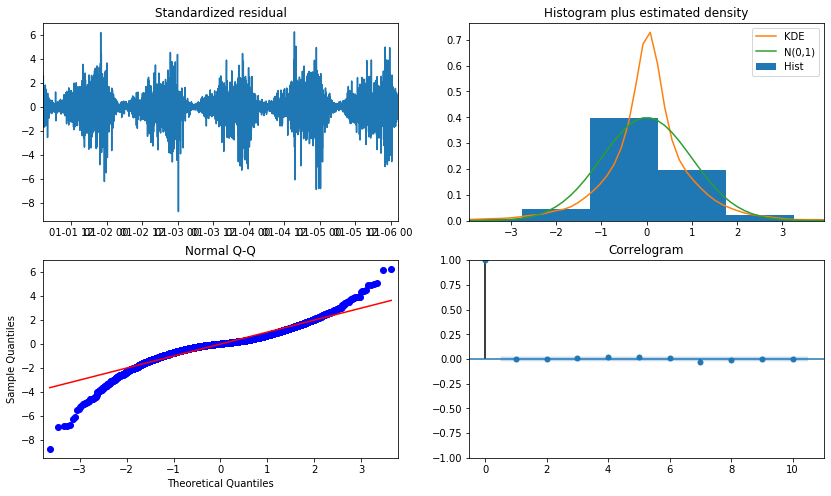

In [96]:
model.plot_diagnostics(figsize = (14, 8))
plt.show()

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

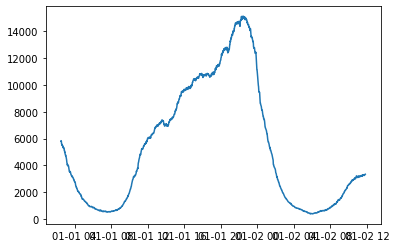

In [147]:
plt.plot(ser[0:2000])

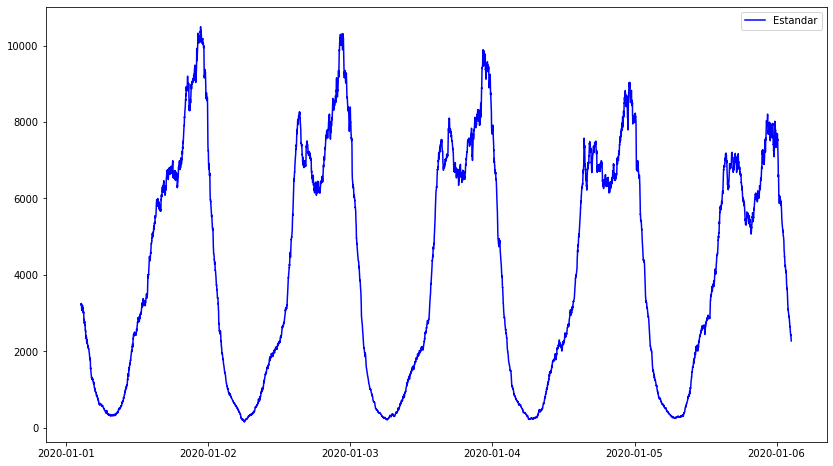

0.9497027922950351


In [97]:
lags = 1400
plt.figure(figsize=(14,8))
plt.plot(pr3['Target'],label='Estandar', color = 'blue')
#plt.plot(ser[:].shift(lags), label='Desplazado', color = 'red')
plt.legend()

plt.show()
print(ser.corr(ser.shift(lags)))

In [17]:
511000

511000

<Figure size 1008x576 with 0 Axes>

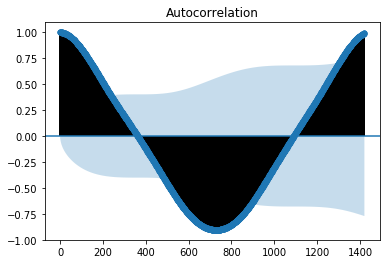

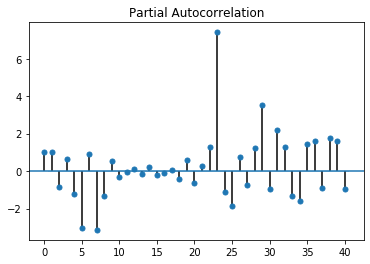

In [92]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(pr3,lags = 1420, unbiased = True)
plot_pacf(pr3, lags = 40)
plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
adfuller(ser)

(-3.0844195555866216,
 0.027727903930146548,
 35,
 7164,
 {'1%': -3.43126312739421,
  '5%': -2.8619435304007217,
  '10%': -2.5669847951004168},
 76504.63714292817)

In [35]:
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-01 04:17:00')) & (df1['Cadena']== 'REAL MADRID HD')]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
174475,2020-01-01 04:17:00,HOY JUGAMOS,REAL MADRID HD,DEPORTES,FAMILIAR,REAL MADRID MULTIMEDIA,Sin Preaviso,"[0.012, 0.0, 0.0, 0.013, 5.205, 0.0, 0.0, 5.205]"
174605,2020-01-01 04:17:00,CONECTA ENTREVISTA / HUGO SANCHEZ,REAL MADRID HD,INFORMACIÓN,FAMILIAR,REAL MADRID MULTIMEDIA,Todos los Públicos,"[0.012, 0.0, 0.0, 0.013, 5.205, 0.0, 0.0, 5.205]"


In [14]:
df1[df1['Cadena'] == 'BOING'].iloc[114:120,:]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
109696,2020-01-01 02:26:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109697,2020-01-01 02:27:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109698,2020-01-01 02:28:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109699,2020-01-01 02:29:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109700,2020-01-01 02:30:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
109701,2020-01-01 02:31:00,MR.BEAN-DIBUJOS,BOING,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [21]:
df1[df1['Cadena'] == 'BOING'].iloc[1620:1654,:]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
266584,2020-01-02 05:28:00,THE HAPPOS FAMILY,BOING,FICCIÓN,FAMILIAR,BOOMERANG,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266585,2020-01-02 05:30:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266586,2020-01-02 05:31:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266587,2020-01-02 05:32:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266588,2020-01-02 05:33:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266589,2020-01-02 05:34:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266590,2020-01-02 05:35:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266591,2020-01-02 05:36:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266592,2020-01-02 05:37:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
266593,2020-01-02 05:38:00,EL SHOW DE TOM Y JERRY,BOING,FICCIÓN,FAMILIAR,WARNER BROS ANIMATION,Todos los Públicos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [1]:
counter = 0
for i,v in enumerate(df1[df1['Cadena'] == 'BOING'].Target):
        if len(np.where(v == 0.0)[0]) == 8  :
            print(i,v)
            counter+=1
print(counter)

NameError: name 'df1' is not defined

In [4]:
X = df1.drop(['Target','Fecha_comp'], axis=1)
y = df1.Target
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [7]:
cop.head()

,Cadena_#VAMOS,Cadena_24H,Cadena_3/24,Cadena_8MADRID,Cadena_8TV,Cadena_A PUNT,Cadena_A3,Cadena_AMC,Cadena_AND-TV,Cadena_ARAGON TV,...,Calificación de Edad_+13 años permanente,Calificación de Edad_+16 años no permanente,Calificación de Edad_+16 años permanente,Calificación de Edad_+18 años no permanente,Calificación de Edad_+18 años permanente,Calificación de Edad_+7 años,Calificación de Edad_Especial Infancia,Calificación de Edad_Sin Clasificar,Calificación de Edad_Sin Preaviso,Calificación de Edad_Todos los Públicos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
#ANALIZAMOS CUANTAS DESCONEXIONES REGIONALES CONTIENE CADA CADENA
df1[df1['Título/Descripción'].str.contains('D.REG')].pivot_table(index=['Cadena'], aggfunc='size').sort_values(ascending=False)

Cadena
La2     367
La1     239
T5        9
A3        9
NOVA      7
dtype: int64

In [5]:
#CUENTO DUPLICADOS PARA CADA CADENA
counter = 1
for i in df1.Cadena.unique():
    print(counter)
    print(i,'-----', df1[df1['Cadena'] == i ].pivot_table(index=['Fecha_comp'], aggfunc='size').unique())
    counter += 1

1
La1 ----- [ 1  2 15 16 17  3 18  4]
2
La2 ----- [1 2 3 5 4]
3
T5 ----- [1 2 3]
4
A3 ----- [1 2 3 4]
5
CUATRO ----- [1]
6
LA SEXTA ----- [1 2]
7
24H ----- [1 2 3]
8
NEOX ----- [1 2]
9
NOVA ----- [1 2 3 4 5]
10
AXN ----- [1]
11
BARÇA TV ----- [1 2]
12
BLAZE ----- [1]
13
HISTORIA ----- [1 2 3]
14
MOVISTAR ACCION ----- [1]
15
MOVISTAR COMEDIA ----- [1]
16
MOVISTAR DRAMA ----- [1]
17
MOVISTAR DEPORTES ----- [2 1 3]
18
CALLE 13 ----- [1]
19
CANAL COCINA ----- [1]
20
CANAL HOLLYWOOD ----- [1]
21
CAZA Y PESCA ----- [1]
22
SUNDANCE TV ----- [1 2]
23
CLAN ----- [1 2]
24
COSMOPOLITAN ----- [1 2]
25
DARK ----- [1 2]
26
MOVISTAR CINE ESPAÑOL ----- [1]
27
DECASA ----- [1 2 3]
28
DISCOVERY ----- [1 2]
29
DISNEY CH +1 ----- [1 2]
30
DISNEY CHANNEL ----- [1 2]
31
EUROSPORT ----- [1 2]
32
XTRM ----- [1 2]
33
FDF ----- [1 2]
34
FOX ----- [1]
35
MOVISTAR GOLF ----- [1 2]
36
MTV ESP ----- [1 2 3]
37
NATIONAL GEOGRAPHIC ----- [1]
38
NICKELODEON ----- [1 2]
39
ODISEA ----- [1 2]
40
PANDA ----- [1 2]
41
COM

In [105]:
#VISUALIZO LAS MARCAS HORARIAS QUE TIENEN MULTIPLES REGISTROS
pd.set_option('display.max_rows', None)
df1[df1['Cadena'] == 'REAL MADRID HD'].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-01 04:17:00    3
2020-01-04 10:47:00    3
2020-01-02 12:33:00    3
2020-01-02 12:32:00    3
2020-01-02 12:31:00    3
2020-01-02 12:30:00    3
2020-01-04 01:12:00    3
2020-01-02 12:26:00    3
2020-01-03 00:05:00    3
2020-01-01 06:07:00    3
2020-01-05 13:57:00    3
2020-01-02 04:27:00    3
2020-01-03 06:11:00    3
2020-01-01 01:31:00    3
2020-01-02 08:16:00    3
2020-01-01 11:58:00    3
2020-01-03 01:49:00    3
2020-01-02 12:34:00    3
2020-01-01 11:08:00    3
2020-01-01 01:09:00    3
2020-01-01 11:07:00    3
2020-01-02 06:10:00    3
2020-01-03 04:27:00    3
2020-01-03 10:28:00    3
2020-01-02 23:07:00    3
2020-01-01 10:33:00    3
2020-01-01 09:16:00    3
2020-01-04 00:22:00    3
2020-01-01 10:49:00    3
2020-01-01 08:56:00    3
2020-01-02 01:03:00    3
2020-01-04 18:29:00    3
2020-01-01 23:10:00    3
2020-01-01 23:09:00    3
2020-01-03 22:32:00    3
2020-01-01 03:23:00    3
2020-01-04 08:49:00    3
2020-01-01 09:55:00    3
2020-01-03 12:34:00    3
2020-01-03 12:

In [107]:
#VISUALIZO LOS REGISTROS QUE REPITEN UNA MARCA HORARIA DETERMINADA
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-03 14:19:00')) & (df1['Cadena']== 'REAL MADRID HD')]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
456649,2020-01-03 14:19:00,CINE / MADISON,REAL MADRID HD,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.08, 0.094, 0.0, 0.092, 36.059, 17.385, 0.0,..."


In [81]:
#OBSERVO CUANTOS REGISTROS CON DESC. REG. HAY POR MARCA HORARIA
df1[(df1['Título/Descripción'].str.contains('D.REG'))&(df1['Cadena']=='La1')].pivot_table(index=['Fecha_comp'], aggfunc='size')

Fecha_comp
2020-01-02 11:59:00    1
2020-01-02 12:00:00    1
2020-01-02 12:01:00    1
2020-01-02 12:02:00    1
2020-01-02 12:03:00    1
2020-01-02 12:04:00    1
2020-01-02 12:05:00    1
2020-01-02 12:06:00    1
2020-01-02 12:07:00    1
2020-01-02 12:08:00    1
2020-01-02 12:09:00    1
2020-01-02 12:10:00    1
2020-01-02 12:11:00    1
2020-01-02 12:12:00    1
2020-01-02 12:13:00    1
2020-01-02 12:14:00    1
2020-01-02 12:15:00    1
2020-01-02 12:16:00    1
2020-01-02 12:17:00    1
2020-01-02 12:18:00    1
2020-01-02 12:19:00    1
2020-01-02 12:20:00    1
2020-01-02 12:21:00    1
2020-01-02 12:22:00    1
2020-01-02 12:23:00    1
2020-01-02 12:24:00    1
2020-01-02 12:25:00    1
2020-01-02 12:26:00    1
2020-01-02 14:00:00    1
2020-01-02 14:01:00    1
2020-01-02 14:02:00    1
2020-01-02 14:03:00    1
2020-01-02 14:04:00    1
2020-01-02 14:05:00    1
2020-01-02 14:06:00    1
2020-01-02 14:07:00    1
2020-01-02 14:08:00    1
2020-01-02 14:09:00    1
2020-01-02 14:10:00    1
2020-01-02 14:

In [44]:
#CREO EL DATA FRAME CON LAS VARIABLES CATEGÓRICAS
df_cat = df1[['Cadena', 'Género', 'Público objetivo', 'Productora','Calificación de Edad']]

In [40]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [41]:
X = df1.drop(['Target','Fecha_comp'], axis=1)
y = df1.Target
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [9]:
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [18]:
y_2 = df1.Target[0]

0.88

In [42]:
cop.dtypes.unique()

array([dtype('uint8')], dtype=object)

In [33]:
reg = LinearRegression()

In [51]:
# Load the library
from sklearn.tree import DecisionTreeRegressor
# Create an instance
regd = DecisionTreeRegressor()
# Fit the data
cross_val_score(regd, cop, y, cv = 6 , scoring='neg_mean_absolute_error')

array([-191.86927908, -125.92345073, -121.88574354, -148.1359765 ,
       -125.7144029 ,  -71.86962425])

In [54]:
# Load the library
from sklearn.ensemble import RandomForestRegressor
# Create an instance
clf = RandomForestRegressor(max_depth=4)
# Fit the data
cross_val_score(clf, cop, y,cv = 3 , scoring='neg_mean_absolute_error')

KeyboardInterrupt: 